# Code for fig2

In [1]:
import os
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

## Prepare inputs

Settings and path

In [2]:
## input data from peat_exp_analysis/v25, copied in folder ../data
path_data = '../data'
## set path for storing the figure made by this file
path_fig = '../fig'

prepare data

In [3]:
## read in the data
## mask to filter out negative scenarios from input - to filter out scenarios that were not used in the experiment
TMP = xr.open_dataset(path_data + '/ds_subset_mask.nc')
ds_eff_mask = TMP.copy(deep=True)
## mask to filter out negative scenarios from output - to filter out scenarios with negative D_CO2 by 2300 (not used in analysis)
TMP = xr.open_dataset(path_data + '/ds_dco2_mask.nc')
ds_dco2_mask = TMP.copy(deep=True)
## non-overshoot related calculations
TMP = xr.open_dataset(path_data + '/ds_calc_nov.nc')
ds_calc_nov = TMP.copy(deep=True)
TMP = xr.open_dataset(path_data + '/ds_calc_nov_pt.nc')
ds_calc_nov_pt = TMP.copy(deep=True)
TMP = xr.open_dataset(path_data + '/ds_calc_nov_pt_obelix.nc')
ds_calc_nov_pt_obelix = TMP.copy(deep=True)

colors

In [4]:
lst_ssp=['SSP1-1.9', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP4-3.4','SSP4-6.0', 'SSP5-3.4-OS']
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88', '#ffbcaf', '#f4777f', '#cf3759', '#93003a'] 
col_ssp_dsk = {'SSP1-1.9': '#00429d','SSP1-2.6': '#4771b2', 'SSP2-4.5':'#73a2c6', 'SSP3-7.0':'#ffcc88','SSP4-3.4': '#ffbcaf',
                 'SSP4-6.0':'#f4777f', 'SSP5-3.4-OS':'#cf3759','SSP5-8.5':'#83003a'}  

mask to select non-extreme values

In [5]:
# make a mask for selecting non-extreme values
mask_scen = ds_dco2_mask['mask_dco2'].drop(['year','var_name'])
mask_tg = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg') <= 200
mask_co2 = ds_calc_nov_pt['best_guess'].sel(var_name='D_CO2') <= 3000
mask_ept_co2 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2') <= 0.07

# Combine the masks using logical OR to check if any criteria is met along the 'scen' dimension, including all four masks above
combined_mask = ~((~mask_tg).any(dim='year') & (~mask_co2).any(dim='year') & (~mask_ept_co2).any(dim='year')).drop('var_name')
combined_mask = combined_mask.where(mask_scen, drop=True)

## Make subplots

3Dplot

/Users/bqzhu/opt/anaconda3/envs/myvenv_fire/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


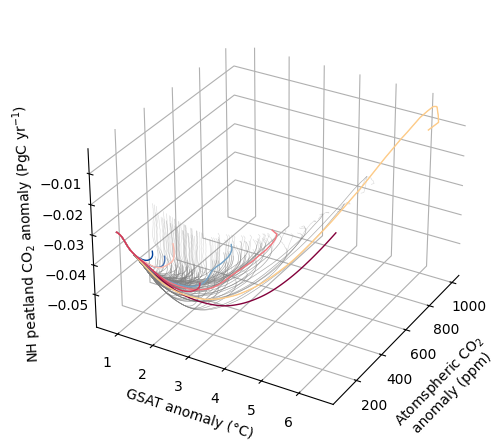

In [6]:
ds_filtered = xr.concat([ds_calc_nov_pt.where(combined_mask, drop=True),ds_calc_nov_pt.sel(scen='SSP5-8.5')], dim='scen')
ds_filtered_obelix = xr.concat([ds_calc_nov_pt_obelix.where(combined_mask, drop=True),ds_calc_nov_pt_obelix.sel(scen='SSP5-8.5')], dim='scen')

## plot data
ds1 = ds_filtered['best_guess'].sel(var_name='D_Tg').rolling(year=11, center=True).mean()
ds2 = ds_filtered['best_guess'].sel(var_name='D_CO2').rolling(year=11, center=True).mean()
ds3 = ds_filtered_obelix['best_guess'].sel(var_name='D_Ept_CO2').rolling(year=11, center=True).mean()
ds4 = ds_filtered_obelix['best_guess'].sel(var_name='D_Ept_CH4').rolling(year=11, center=True).mean()

## plot
fig = plt.figure(figsize=(5., 5.))
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
for sn in ds_filtered_obelix.scen.values:
    if sn != 'SSP5-8.5':
        YRpeak = ds_filtered['Tpeak_yr_bg'].sel(scen=sn).values
        xline = ds1.sel(scen = sn,year=slice(2000,YRpeak)).values
        yline = ds2.sel(scen = sn,year=slice(2000,YRpeak)).values
        zline = ds3.sel(scen = sn,year=slice(2000,YRpeak)).values
        ax.plot3D(xline, yline, zline, 'gray', alpha=0.3, linewidth=0.4)
    if sn=='SSP5-8.5':
        xline = ds1.sel(scen = sn,year=slice(2000,2100)).values
        yline = ds2.sel(scen = sn,year=slice(2000,2100)).values
        zline = ds3.sel(scen = sn,year=slice(2000,2100)).values
        ax.plot3D(xline, yline, zline, color = col_ssp_dsk[sn],alpha=1,linewidth=1)
for sn in lst_ssp:
    YRpeak = ds_filtered['Tpeak_yr_bg'].sel(scen=sn).values
    xline = ds1.sel(scen = sn,year=slice(2000,YRpeak)).values
    yline = ds2.sel(scen = sn,year=slice(2000,YRpeak)).values
    zline = ds3.sel(scen = sn,year=slice(2000,YRpeak)).values
    ax.plot3D(xline, yline, zline, color=col_ssp_dsk[sn], alpha=1, linewidth=1)
## set axis on the left side
#ax = fig.add_axes(MyAxes3D(ax, 'l'))
# Set axis labels
ax.set_xlabel('GSAT anomaly (\u00B0C)')
ax.set_ylabel('Atomspheric CO$_2$ \nanomaly (ppm)')
#ax.set_zlabel('NH peatland CO$_2$ \nanomaly (PgC yr$^{-1}$)', rotation=90)
# Set the label text for the z-axis
#z_label = ax.set_zlabel('NH peatland CO$_2$ \nanomaly (PgC yr$^{-1}$)', labelpad=20)

# Rotate the z-axis label by 180 degrees
ax.text2D(-0.13, 0.47, 'NH peatland CO$_2$ anomaly (PgC yr$^{-1}$)', transform=ax.transAxes, rotation=93, va='center')

# Customize your plot as needed
# Increase the space between the axis label and the axis numbers so that the label doesn't overlap with the tick labels
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
# Change the plot background color to white
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 1.0))
ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 1.0))
ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 1.0))
## move the z-axis to the left, from https://stackoverflow.com/questions/48442713/move-spines-in-matplotlib-3d-plot/49601745#49601745 
ax.zaxis._axinfo['juggled'] = (1,2,0)
# Set the label text for the z-axis
plt.tight_layout()
plt.savefig(path_fig+'/sub_fig2_3D_beforePeak-left.png', dpi=300, bbox_inches='tight')

2D plot D_Ept_CH4 and D_Tg

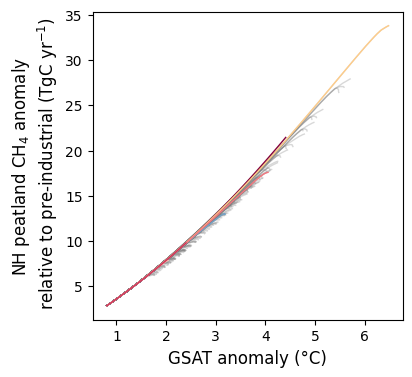

In [7]:
fig = plt.figure(figsize=(4., 4.))
##plot while excluding SSP5-8.5
lst_sn = [sn for sn in ds1['scen'].values if sn != 'SSP5-8.5']
for sn in lst_sn:
    YRpeak = ds_calc_nov_pt['Tpeak_yr_bg'].sel(scen=sn).values
    plt.plot(ds1.sel(scen=sn,year=slice(2000,min(YRpeak,2290))),ds4.sel(scen=sn,year=slice(2000,min(YRpeak,2290))),color = 'gray', alpha = 0.3, lw=1)
plt.plot(ds1.sel(scen = 'SSP5-8.5',year=slice(2000,2100)),ds4.sel(scen = 'SSP5-8.5',year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], alpha = 1, lw=1)
for sn in lst_ssp:
    YRpeak = ds_calc_nov_pt['Tpeak_yr_bg'].sel(scen=sn).values
    plt.plot(ds1.sel(scen = sn,year=slice(2000,min(YRpeak,2290))),ds4.sel(scen = sn,year=slice(2000,min(YRpeak,2290))),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.xlabel('GSAT anomaly (\u00B0C)', fontsize = 12)
plt.ylabel('NH peatland CH$_4$ anomaly \n relative to pre-industrial (TgC yr$^{-1}$)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig2_cor_CH4_beforePeak.png', dpi=300, bbox_inches='tight')

2D plot deltaT and D_Tg

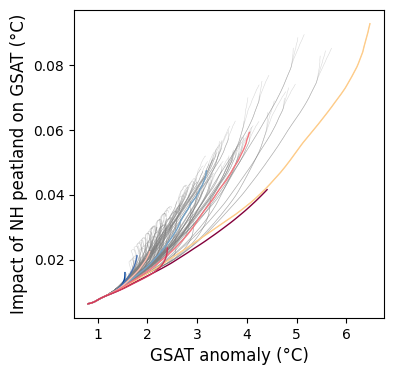

In [8]:
ds_filtered_nonpt = xr.concat([ds_calc_nov.where(combined_mask, drop=True),ds_calc_nov.sel(scen='SSP5-8.5')], dim='scen')
ds5 = ds_filtered_nonpt['best_guess'].sel(var_name='D_Tg').rolling(year=11, center=True).mean()

fig = plt.figure(figsize=(4., 4.))
for sn in lst_sn:
    YRpeak = ds_calc_nov_pt['Tpeak_yr_bg'].sel(scen=sn).values
    plt.plot(ds1.sel(scen=sn,year=slice(2000,min(YRpeak,2290))),(ds1-ds5).sel(scen=sn,year=slice(2000,min(YRpeak,2290))),color = 'gray', alpha = 0.3, lw=0.4)
plt.plot(ds1.sel(scen = 'SSP5-8.5',year=slice(2000,2100)),(ds1-ds5).sel(scen = 'SSP5-8.5',year=slice(2000,2100)),color = col_ssp_dsk['SSP5-8.5'], alpha = 1, lw=1)
for sn in lst_ssp:
    YRpeak = ds_calc_nov_pt['Tpeak_yr_bg'].sel(scen=sn).values
    plt.plot(ds1.sel(scen = sn,year=slice(2000,min(YRpeak,2290))),(ds1-ds5).sel(scen = sn,year=slice(2000,min(YRpeak,2290))),color = col_ssp_dsk[sn], alpha = 1, lw=1)
plt.xlabel('GSAT anomaly (\u00B0C)', fontsize = 12)
plt.ylabel('Impact of NH peatland on GSAT (\u00B0C)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig2_cor_deltaT_beforePeak.png', dpi=300, bbox_inches='tight')

Combine plots

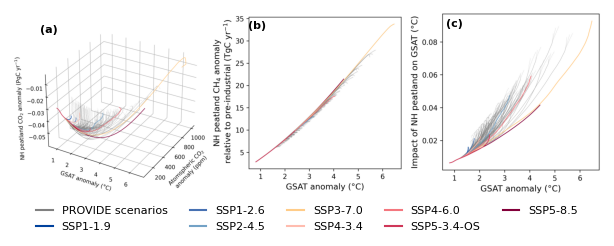

In [9]:
## combine six saved figures into one
fig, axs = plt.subplots(1, 3, figsize=(6, 4))
axs = axs.ravel()
## read in plot Eff
axs[0].imshow(plt.imread(path_fig+'/sub_fig2_3D_beforePeak-left.png'))
## read in plot D_Tg
axs[1].imshow(plt.imread(path_fig+'/sub_fig2_cor_CH4_beforePeak.png'))
## read in plot D_CO2
axs[2].imshow(plt.imread(path_fig+'/sub_fig2_cor_deltaT_beforePeak.png'))
## add labels to each subplot to the top left corner
axs[0].text(0.15, 0.95, '(a)', transform=axs[0].transAxes, fontsize=8, fontweight='bold', va='top')
axs[1].text(0.20, 0.95, '(b)', transform=axs[1].transAxes, fontsize=8, fontweight='bold', va='top')
axs[2].text(0.20, 0.95, '(c)', transform=axs[2].transAxes, fontsize=8, fontweight='bold', va='top')
## remove the box around each subplot
for ax in axs:
    ax.axis('off')
## generate legends for all subplots together. I want to add a legend for each color, but only once for each color.
## first define the colors and labels, colors are from col_ssp_dsk, all labels are solid lines with corresponding color
col_ssp_dsk = {'PROVIDE scenarios':'gray','SSP1-1.9': '#00429d','SSP1-2.6': '#4771b2', 'SSP2-4.5':'#73a2c6', 'SSP3-7.0':'#ffcc88','SSP4-3.4': '#ffbcaf',
                    'SSP4-6.0':'#f4777f', 'SSP5-3.4-OS':'#cf3759','SSP5-8.5':'#83003a'}
labels = ['PROVIDE scenarios','SSP1-1.9', 'SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP4-3.4','SSP4-6.0', 'SSP5-3.4-OS', 'SSP5-8.5']
# Create a legend for the colors and labels with manual location
legend = axs[1].legend(handles=[plt.Line2D([0], [0], color=col_ssp_dsk[label], label=label) for label in labels],
                       bbox_to_anchor=(0.5, -0.0), loc='upper center', ncol=5, fontsize=8, frameon=False, handlelength=1.5)
# Adjust the spacing between subplots to make them tighter
plt.subplots_adjust(top=0.99, bottom=0.1, left=0.01, right=1., hspace=-0.02, wspace=-0.)
# Ensure that the legend is within the figure
#plt.tight_layout()
## Save as PNG
plt.savefig(path_fig+'/figure2.png', dpi=300, bbox_inches='tight')
## Save as PDF
plt.savefig(path_fig + '/figure2.pdf', bbox_inches='tight')